# Density estimation
_________
###  Table of content

[1. Data](#data)<br>
[2. Histogram density estimation](#histogram)<br>
[3. Empirical cumulative distribution function](#ecdf)<br>
[4. Kernel density estimation](#kernel)<br>
[5. Switching Model Regression](#switching)<br>
_________

### Importations

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors.kde import KernelDensity

<a id='data'></a>
# Data

In [2]:
df_rwanda = pd.read_csv('./data/rwanda')

X = df_rwanda['mean_light']
y = df_rwanda['wealth_index']

X = np.resize(X, (X.shape[0], 1))
y = np.resize(y, (y.shape[0], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Data is splited into 3 parts, by comparaison of the mean_light variable to the separator value :
 - values equal to 0 : X_0 and y_0
 - values between 0 and the separator : X_low and y_low
 - values higher than the separator : X_high and y_high

In [3]:
sep = 3

X_low, y_low, X_high, y_high, X_0, y_0 = [], [], [], [], [], []
for i in range(X.shape[0]):
    if X[i][0] == 0:
        X_0.append(X[i])
        y_0.append(y[i])
    elif X[i][0] <= sep:
        X_low.append(X[i])
        y_low.append(y[i])
    else:
        X_high.append(X[i])
        y_high.append(y[i])
        
X_0 = np.resize(X_0, (len(X_0), 1))
y_0 = np.resize(y_0, (len(y_0), 1))
X_low = np.resize(X_low, (len(X_low), 1))
y_low = np.resize(y_low, (len(y_low), 1))
X_high = np.resize(X_high, (len(X_high), 1))
y_high = np.resize(y_high, (len(y_high), 1))

### Data visualization

#### All data

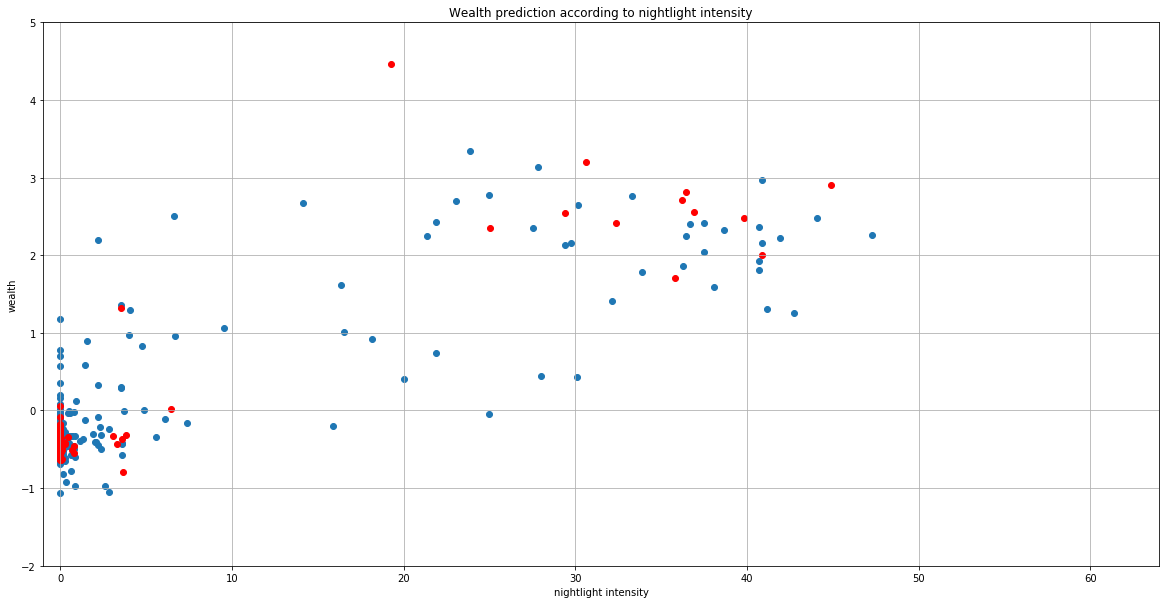

In [4]:
plt.figure(figsize=(20, 10))
plt.grid()
plt.xlim(-1, 64)
plt.ylim(-2, 5)
plt.title('Wealth prediction according to nightlight intensity')
plt.xlabel('nightlight intensity')
plt.ylabel('wealth')
plt.scatter(X_train, y_train)
plt.scatter(X_test, y_test, color='r')
plt.show()

#### Values equal to 0

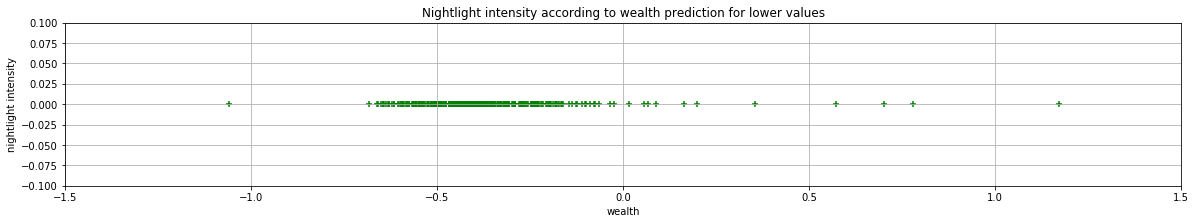

In [5]:
plt.figure(figsize=(20, 3))
plt.grid()
plt.xlim(-1.5, 1.5)
plt.ylim(-0.1, 0.1)
plt.title('Nightlight intensity according to wealth prediction for lower values')
plt.ylabel('nightlight intensity')
plt.xlabel('wealth')
plt.scatter(y_0, X_0, color='g', marker='+')
plt.show()

#### Lower values

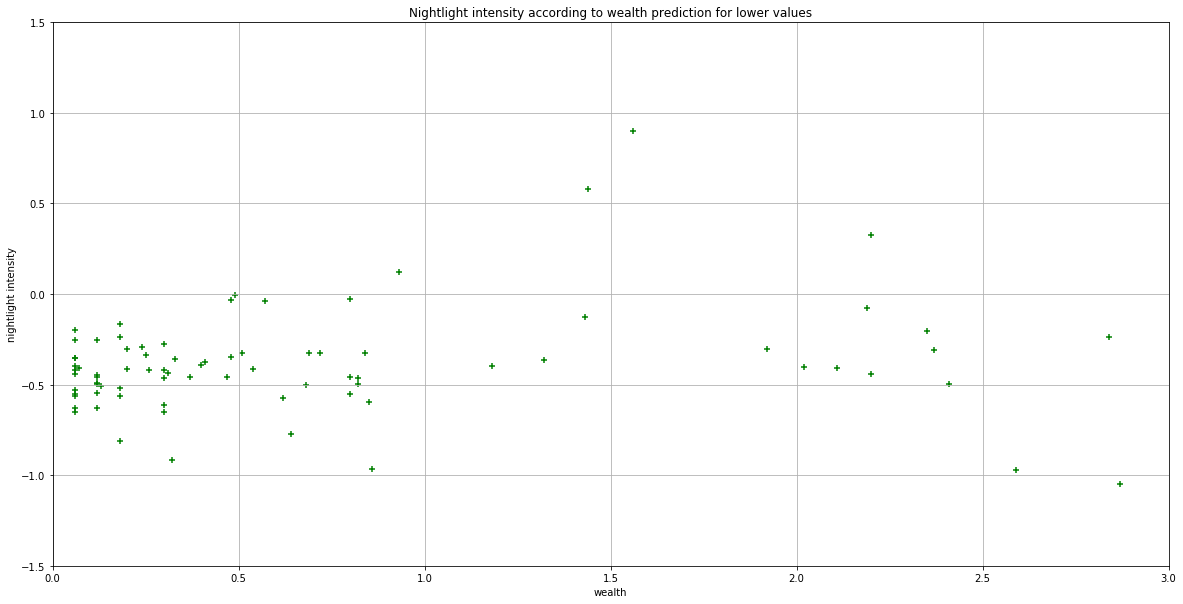

In [6]:
plt.figure(figsize=(20, 10))
plt.grid()
plt.ylim(-1.5, 1.5)
plt.xlim(0, 3)
plt.title('Nightlight intensity according to wealth prediction for lower values')
plt.ylabel('nightlight intensity')
plt.xlabel('wealth')
plt.scatter(X_low, y_low, color='g', marker='+')
plt.show()

#### Higher values

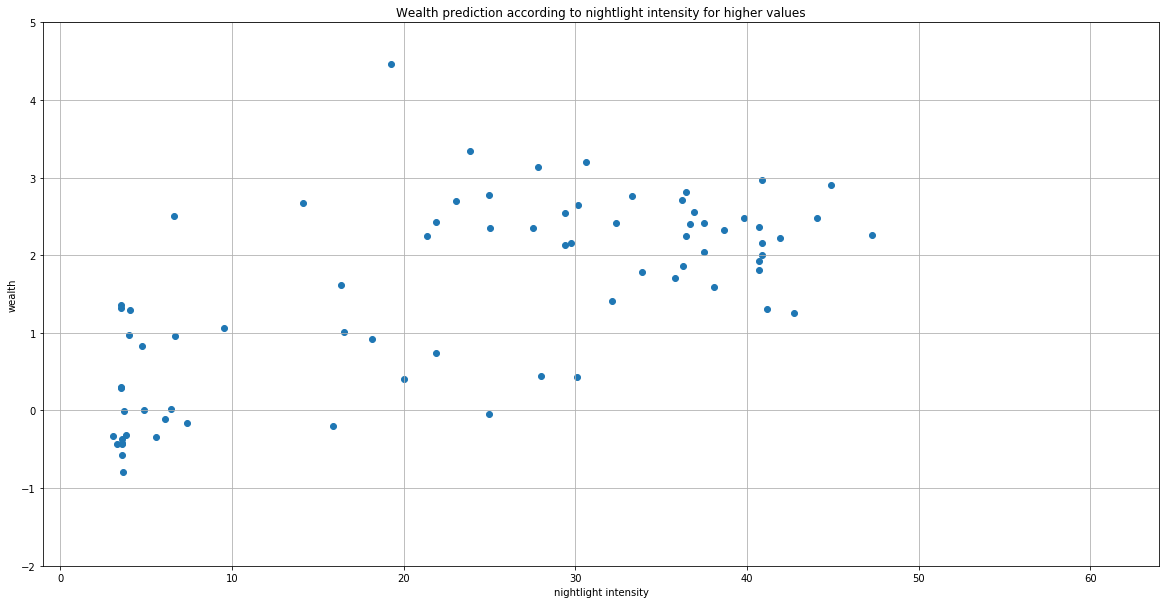

In [7]:
plt.figure(figsize=(20, 10))
plt.grid()
plt.xlim(-1, 64)
plt.ylim(-2, 5)
plt.title('Wealth prediction according to nightlight intensity for higher values')
plt.xlabel('nightlight intensity')
plt.ylabel('wealth')
plt.scatter(X_high, y_high)
plt.show()

#### Sizes

In [8]:
print("X_0 : " + str(np.shape(X_0)))
print("X_low : " + str(np.shape(X_low)))
print("X_high : " + str(np.shape(X_high)))

X_0 : (335, 1)
X_low : (81, 1)
X_high : (76, 1)


#### Cross-validation data

In [9]:
X_high_train, X_high_test, y_high_train, y_high_test = train_test_split(X_high, y_high, test_size=0.20, random_state=42)
y_low_train, y_low_test = train_test_split(y_low, test_size=0.20, random_state=42)
y_0_train, y_0_test = train_test_split(y_0, test_size=0.20, random_state=42)

y_train = np.concatenate((y_0_train, y_low_train, y_high_train))
y_test = np.concatenate((y_0_test, y_low_test, y_high_test))

<a id='histogram'></a>
# Histogram Density Estimation

A density model is a density function estimation model which requires low computer performance. Histogram density estimation is the easiest among those models.

## a) Definition
Let's write the observations as $(X_1,...,X_n)$ iid random variables with $f$ as their density function, and let's define $(C_1,...,C_m)$ a partition of $[0, 1[$ as :

$$ C_j = [{ \frac{j-1}{m},\frac{j}{m} }[,  j=1,...,m.$$

As $f$ is continue, it can be approched by constant step functions over the intervals $(C_j)$. By writing $h=1/m$, the estimator is :

$$ \bar{f_h}(x) = \sum_{j=1}^{m} \frac{p_j}{h} \mathbb{1}_{C_j}(x),$$

where $p_j=\int_{C_j} f(x)dx$. The estimation problem is now to estimate the parameter $p=(p_1,...,p_m)$. This is solved by using a method of moments :

$$p_j=\int_{C_j} f(x)dx=\mathbb{E}_f[\mathbb{1}_{C_j}(X_1)],j=1,...,m.$$

$p$ can be estimated by using :

$$\hat{p_j}=\frac{1}{n}\sum_{i=1}^{n}\mathbb{1}_{C_j}(X_i).$$

Each $\hat{p_j}$ represents the **proportion** of $X_i$ that $C_j$ contains. Finally, the **estimator** is :

$$ \hat{f_h}(x)=\frac{1}{h}\sum_{j=1}^{m} \hat{p_j}\mathbb{1}_{C_j}(x). $$

$C_j$ is called a **class** and h a **window**.

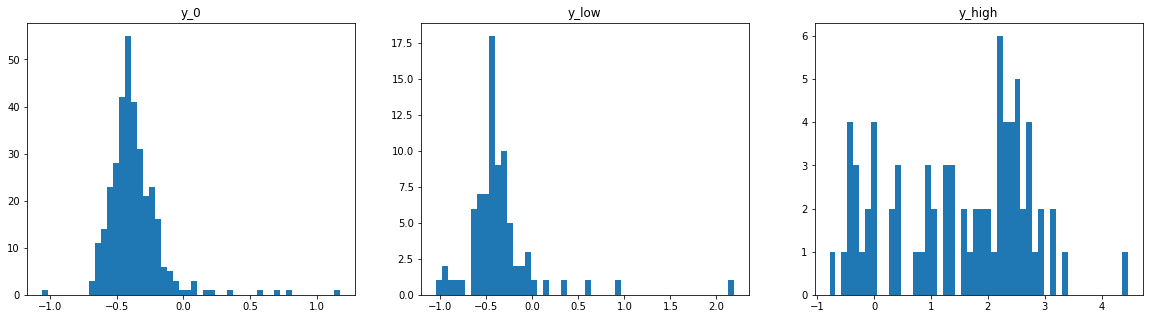

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

b=50

for i, val in enumerate([[y_0, "y_0"], [y_low, "y_low"], [y_high, "y_high"]]):
    ax[i].hist(val[0], bins=b)
    ax[i].set_title(val[1])

## b) Window optimisation

With to the previous estimator, the **mean squared error** can be written :

$$MSE_f(x,h)=\mathbb{E}_f [ (\hat{f_h}(x)-f(x))^2 ], \forall x \in [0,1].$$

If $h$ is  chosen independently from the size of the observation set $n$, the histogram estimator will not converge towards the actual density in general. $h=h_n$ should converge towards $0$ when $n \to +\infty$. 

In order to get a global error for all $x \in [0,1]$, let's introduce the **integrated mean squared error** defined by :

$$MISE_f(h)=\int_0^1 MSE_f(x,h)dx=\mathbb{E}_f [\int_0^1 (\hat{f_h}(x)-f(x))^2dx].$$

Minimizing this error leads to finding the optimal value for the window $h$. The real optimal value $h_{opt}$ can't be directly computed generally, but can be estimated by the following process :

**Proposition :**
*If $f$ is square-integrable density and if $\hat{f_h}$ is the histogram with $m=1/h$ classes based on the observation set $(X_1,...,X_n)$ iid with $f$ as the density function, then*

$$\hat{J}(h,X_1,...,X_n)=\frac{2}{(n-1)h}-\frac{n+1}{(n-1)h}\sum_{j=1}^{m} {\hat{p_j}}^2$$

*is an unbiased estimator of* $MISE_f(h)-{\left\| f\right\|}_2^2$.

The following program is a cross validation algorithm to determine $\hat{h_{opt}}$, as proposed in the [source](#source) document.

In [11]:
def J_sum(a, b, m, n):
    h = (b - a) / m
    res = 0
    for j in range(m):
        temp = 0
        for x in X:
            if (x < a+j*h and x >= a+(j-1)*h):
                temp += 1
        res += (temp / n)**2
    return res

def window_optimisation(X):
    n = np.shape(X)[0]
    a = np.min(X)
    b = np.max(X)
    m = 1
    m_CV = 1
    J_CV = 1
    while (m < n):
        J = m * (2 / (n-1) - (n+1) * J_sum(a, b, m, n) / (n-1))
        if (J < J_CV):
            m_CV = m
            J_CV = J
        m += 1
    return (b - a) / m_CV

Optimal bin width selection is already implemented. We'll use the option "auto".

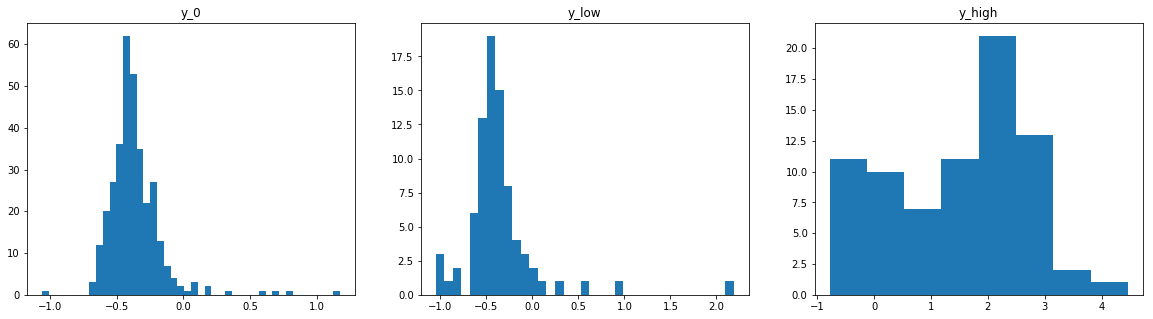

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for i, val in enumerate([[y_0, "y_0"], [y_low, "y_low"], [y_high, "y_high"]]):
    ax[i].hist(val[0], bins='auto')
    ax[i].set_title(val[1])

<a id='ecdf'></a>
# Empirical cumulative distribution function

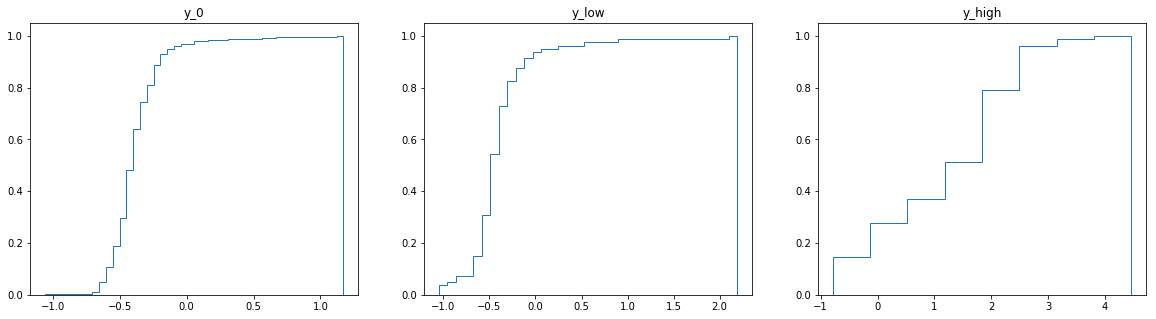

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for i, val in enumerate([[y_0, "y_0"], [y_low, "y_low"], [y_high, "y_high"]]):
    ax[i].hist(val[0], bins='auto', density=True, histtype='step', cumulative=True)
    ax[i].set_title(val[1])

We can use a Kolmogorov-Smirnov test to compare the ECDF with an estimator of the real density function.

#### Estimation from the histograms

 To sample, inverse transform sampling will be used.

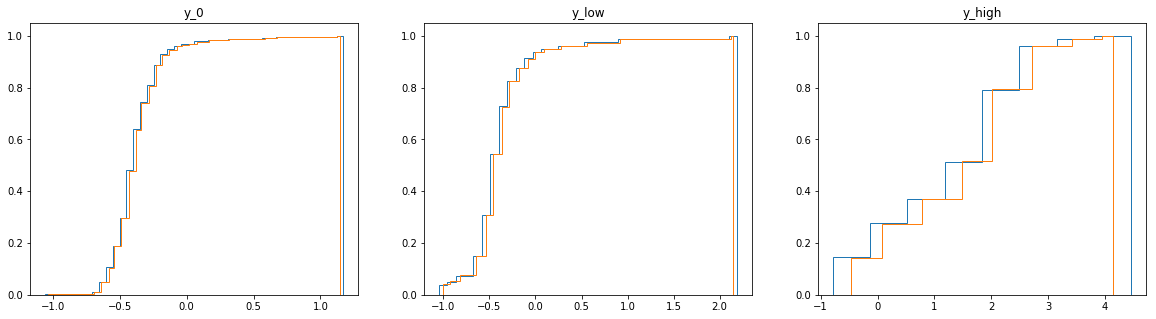

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for i, val in enumerate([[y_0, "y_0"], [y_low, "y_low"], [y_high, "y_high"]]):
    hist, bins = np.histogram(val[0], bins='auto', density=True)
    bin_midpoints = bins[:-1] + np.diff(bins)/2
    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]
    values = np.random.rand(10000)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = bin_midpoints[value_bins]
    
    ax[i].hist(val[0], bins='auto', density=True, histtype='step', cumulative=True)
    ax[i].hist(random_from_cdf, bins='auto', density=True, histtype='step', cumulative=True)
    ax[i].set_title(val[1])

The previous estimation uses the middle of a bin as an estimation for the sample. That explains the shift observed in each graph between the blue and orange histograms.

In [15]:
cdf, bin_midpoints = [], []

for i, val in enumerate([[y_0_train, "y_0"], [y_low_train, "y_low"], [y_high_train, "y_high"]]):
    hist, bins = np.histogram(val[0], bins='auto', density=True)
    bin_midpoints.append(bins[:-1] + np.diff(bins)/2)
    cdf.append(np.cumsum(hist))
    cdf[i] = cdf[i] / cdf[i][-1]

In [16]:
for i, val in enumerate([[y_0_train, y_0_test, "y_0"], [y_low_train, y_low_test, "y_low"], [y_high_train, y_high_test, "y_high"]]):
    mse_test = 0
    mse_train = 0
    for j in range(1000):
        values_train = np.random.rand(np.shape(val[0])[0])
        values_test = np.random.rand(np.shape(val[1])[0])

        value_bins_train = np.searchsorted(cdf[i], values_train)
        value_bins_test = np.searchsorted(cdf[i], values_test)

        values_train = bin_midpoints[i][value_bins_train]
        values_test = bin_midpoints[i][value_bins_test]
        
        mse_train += np.linalg.norm(val[0] - values_train) / val[0].shape[0]
        mse_test += np.linalg.norm(val[1] - values_test) / val[1].shape[0]
        
    print("On " + val[2] + " :")
    print('MSE on train data : ' + str(mse_train / 1000))
    print('MSE on test data : ' + str(mse_test / 1000) + "\n")

On y_0 :
MSE on train data : 0.30143756732572363
MSE on test data : 0.2511341779287481

On y_low :
MSE on train data : 0.5759224875394942
MSE on test data : 0.5374266746828039

On y_high :
MSE on train data : 1.6582837949672282
MSE on test data : 1.7409011971914663



<a id='kernel'></a>
# Kernel Density Estimation

This model is particularly usefull when one has information about the regularity of the density to estimate.

If $x > 0$ is the center of a class in a histogram and that h is its length, then :

$$\hat{f_h^H}(x)=\frac{1}{nh}\sum_{i=1}^n \mathbb{1}(\frac{|X_i−x|}{h} \leq \frac{1}{2}) = \frac{1}{nh}\sum_{i=1}^n K(\frac{X_i−x}{h}),$$

where K is a function defined over $\mathbb{R}$. This function is used to generalized from histograms to a continuous estimator. $K$ is called the **kernel** of this estimator and $h$ is the **window**.

For exemple, the **gaussian kernel** is written :

$$K(u)=\frac{1}{\sqrt{2\pi}}e^{-u^2/2}.$$

If $K$ is positive and $\int_{\mathbb{R}} K(u)du=1$, then $\hat{f_h^H}(x)$ is a probability density function. Moreover, if $K$ is continuous, then $\hat{f_h^H}(x)$ too.

Some calculus shows that this kind of estimation converges faster than the histogram one.

However, bandwidth must be optimal to avoid **over-smoothing** ($h$ too big) and **under-smoothing** ($h$ too small). Cross-validation is usefull to determine $h_{opt}$ in the same way as for the histogram model, but with a different $\hat{J}$ function.

In [17]:
best_bandwidth = []

for i, val in enumerate([[y_0, "y_0"], [y_low, "y_low"], [y_high, "y_high"]]):
    params = {'bandwidth': np.logspace(-1, 1, 20)}
    grid = GridSearchCV(KernelDensity(), params, cv=5, iid=False)
    grid.fit(val[0])
    best_bandwidth.append(grid.best_estimator_.bandwidth)
    print("best bandwidth for " + val[1] +": {0}".format(grid.best_estimator_.bandwidth))

best bandwidth for y_0: 0.1
best bandwidth for y_low: 0.26366508987303583
best bandwidth for y_high: 0.42813323987193935


In [18]:
def kdegraph(kernel_type, distribution=False):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    if distribution:
        fig_d, ax_d = plt.subplots(1, 3, figsize=(20, 5))
    for i, val in enumerate([[y_0, "y_0"], [y_low, "y_low"], [y_high, "y_high"]]):
        kde = KernelDensity(kernel=kernel_type, bandwidth=best_bandwidth[i]).fit(val[0])
        ax[i].set_title('Kernel Density Estimation with ' + kernel_type + ' kernel on ' + val[1])
        ax[i].scatter(val[0], kde.score_samples(val[0]), color='g', marker='+')
        if distribution:
            ax_d[i].hist(val[0], bins='auto', color='r', density=True, histtype='step', cumulative=True)
            ax_d[i].hist(kde.sample(1000), bins='auto', density=True, histtype='step', cumulative=True)
            ax_d[i].set_title('ECDF for the ' + kernel_type + ' kernel on ' + val[1])
    plt.show()    

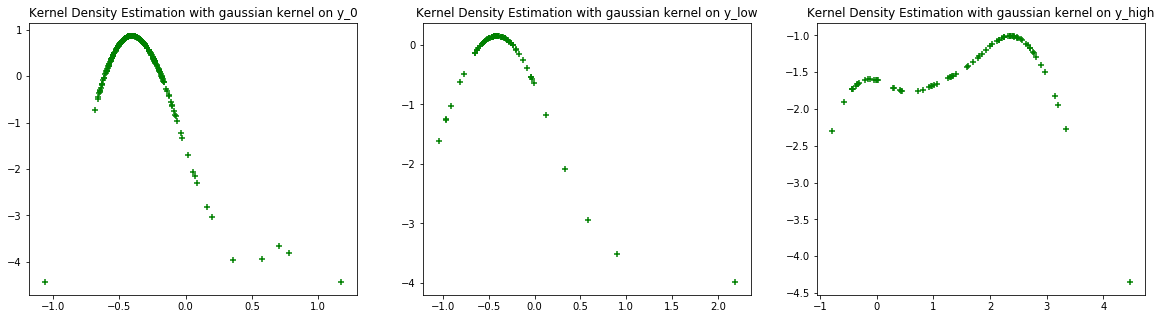

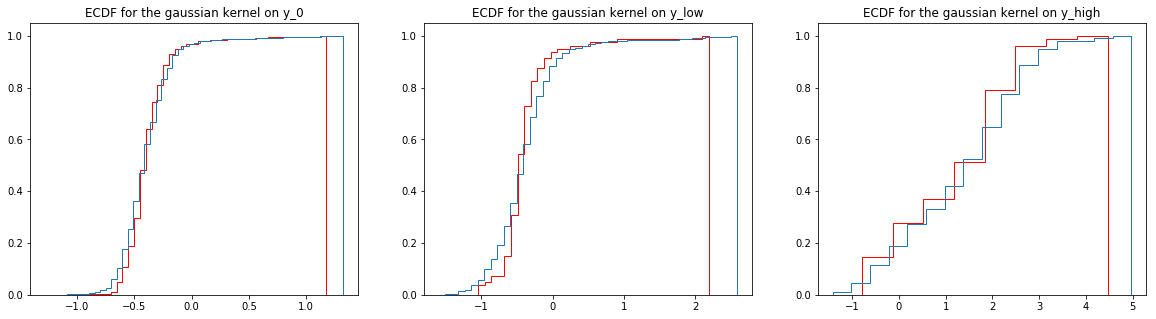

In [19]:
kdegraph('gaussian', distribution=True)

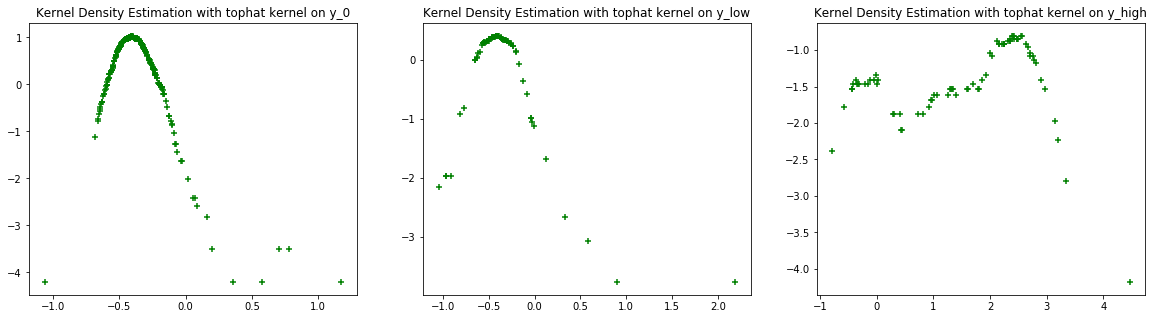

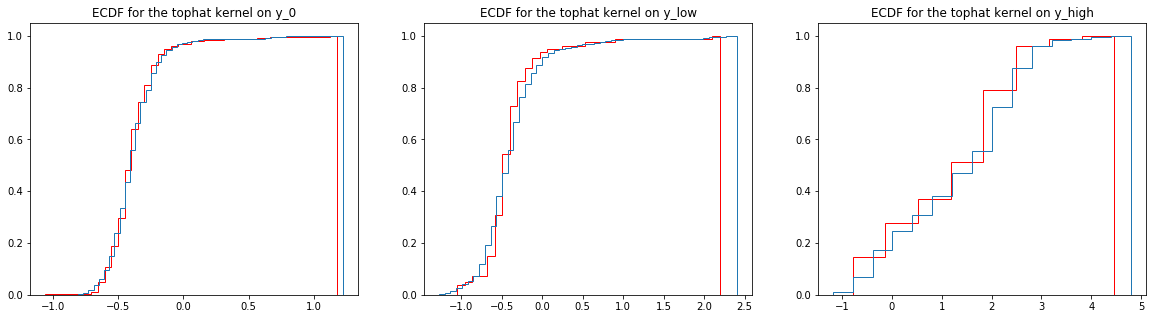

In [20]:
kdegraph('tophat', distribution=True)

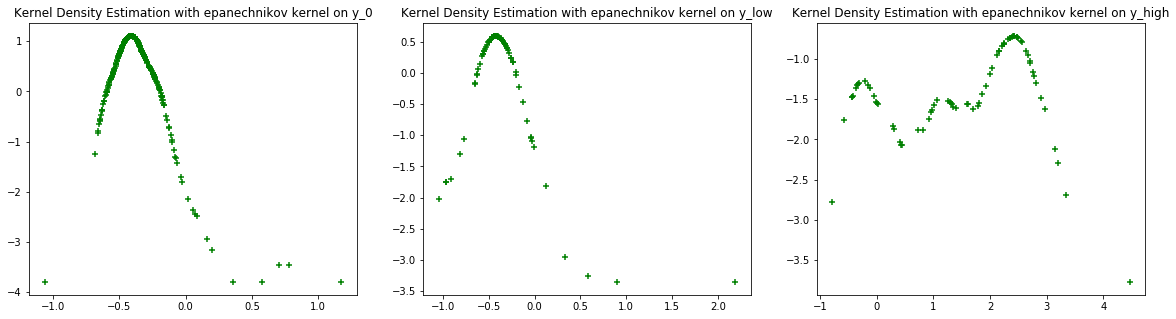

In [21]:
kdegraph('epanechnikov')

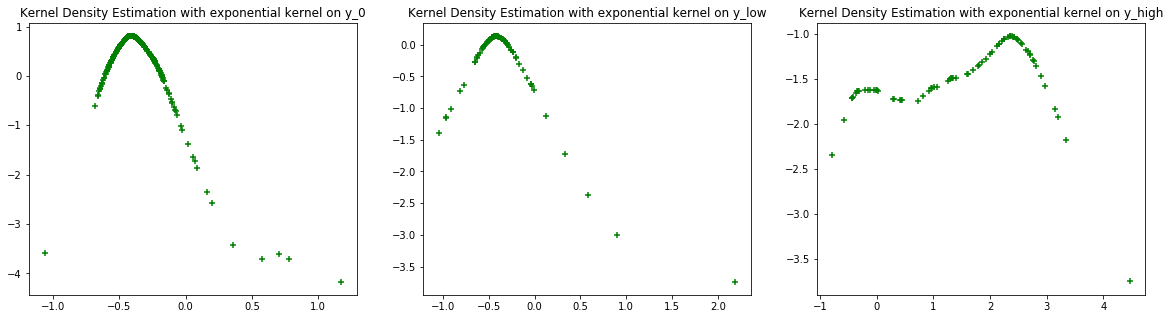

In [22]:
kdegraph('exponential')

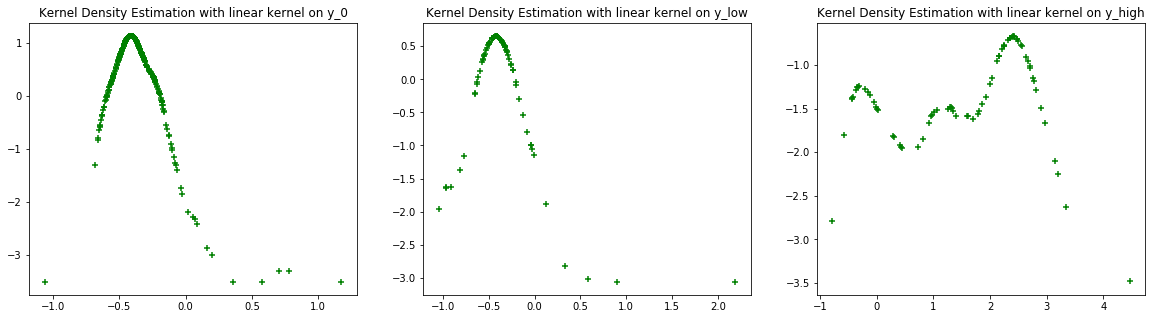

In [23]:
kdegraph('linear')

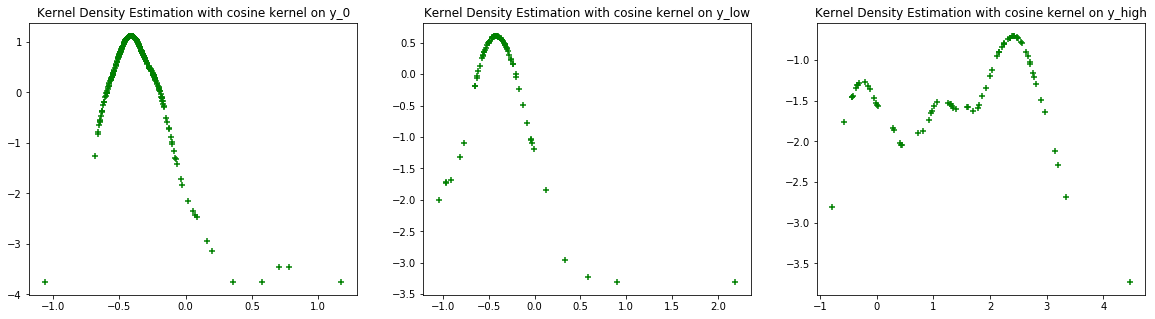

In [24]:
kdegraph('cosine')

Sampling for the epanechnikov, linear, exponential and cosine kernels isn't implemented in sklearn. However, the tophat kernel and gaussian kernels seem good enough when compared to the empirical cumulative distribution function.

In [25]:
for kernel_type in ["gaussian", "tophat"]:
    print("Type of kernel : " + kernel_type)
    for i, val in enumerate([[y_0_train, y_0_test, "y_0"], [y_low_train, y_low_test, "y_low"], [y_high_train, y_high_test, "y_high"]]):
        kde = KernelDensity(kernel=kernel_type, bandwidth=best_bandwidth[i]).fit(val[0])
        mse_test = 0
        mse_train = 0
        for j in range(1000):
            values_train = kde.score_samples(val[0])
            values_test = kde.score_samples(val[1])

            mse_train += np.linalg.norm(val[0] - values_train) / val[0].shape[0]
            mse_test += np.linalg.norm(val[1] - values_test) / val[1].shape[0]

        print("On " + val[2] + " :")
        print('MSE on train data : ' + str(mse_train / 1000))
        print('MSE on test data : ' + str(mse_test / 1000) + "\n")

Type of kernel : gaussian
On y_0 :
MSE on train data : 1.1818409287492768
MSE on test data : 0.9668552589358778

On y_low :
MSE on train data : 0.8454607321239433
MSE on test data : 1.108999009281537

On y_high :
MSE on train data : 3.2050203935878008
MSE on test data : 3.296093375946413

Type of kernel : tophat
On y_0 :
MSE on train data : 1.2686339659578605
MSE on test data : 1.0600332368807168

On y_low :
MSE on train data : 1.0329150332148869
MSE on test data : inf

On y_high :
MSE on train data : 3.1730265427895876
MSE on test data : 3.2947535511834407



A model with 3 gaussian kernel seems appropriate, or one that would predict higher values with a regression model.

**TODO estimation de la variation**

<a id='switching'></a>
# Switching Model Regression

**Needs to be updated to the latest model with gaussians**

##  Utils

In [ ]:
def plot_regression(estimator, X_train, y_train, X_test, y_test):
    x_axis = np.linspace(0, 64, 10000).reshape((10000, 1))
    y_axis = estimator.predict(x_axis)
    plt.figure(figsize=(20, 10))
    plt.grid()
    plt.xlim(-1, 64)
    plt.ylim(-2, 5)
    plt.title('Wealth prediction according to nightlight intensity')
    plt.xlabel('nightlight intensity')
    plt.ylabel('wealth')
    plt.scatter(X_train, y_train)
    plt.scatter(X_test, y_test, color='r')
    plt.plot(x_axis, y_axis)
    plt.show()

In [ ]:
def plot_mse(class_estimator, alpha_min, alpha_max, precision, X_train, y_train, X_test, y_test):
    alpha_list = np.linspace(alpha_min, alpha_max, precision)
    train_MSE = []
    test_MSE = []
    for alpha in alpha_list:
        estimator = class_estimator(int(alpha))
        estimator.train(X_train, y_train)
        train_MSE.append(estimator.train_MSE)
        test_MSE.append(np.linalg.norm(y_test - estimator.predict(X_test)) / y_test.shape[0])
    plt.plot(alpha_list, test_MSE, color='red')
    plt.plot(alpha_list, train_MSE, color='green')
    plt.xlabel('hyperparameter')
    plt.ylabel('MSE')
    plt.grid()
    plt.show()

## Model

The first regime is chosen as the tophat kernel density estimation, and some models are compared in order to chose the second regime.

In [ ]:
class LinearRegression:
    
    def __init__(self):
        self.coeff = None
        self.train_MSE = None
        
    def train(self, X_train, y_train):
        intercept = np.ones((X_train.shape[0], 1))
        X = np.append(intercept, X_train, axis=1)
        beta = scipy.linalg.solve(np.dot(X.T, X), np.dot(X.T, y_train))
        self.coeff = beta
        self.train_MSE = np.linalg.norm(y_train - self.predict(X_train)) / y_train.shape[0]
    
    def predict(self, X_test):
        intercept = np.ones((X_test.shape[0], 1))
        X = np.append(intercept, X_test, axis=1)
        y_test = np.dot(X, self.coeff)
        return y_test

In [ ]:
estimator = LinearRegression()
estimator.train(X_high_train, y_high_train)

plot_regression(estimator, X_high_train, y_high_train, X_high_test, y_high_test)

print('MSE on train data :', estimator.train_MSE)
print('MSE on test data :', np.linalg.norm(y_high_test - estimator.predict(X_high_test)) / y_high_test.shape[0])

In [ ]:
class KernelSmoothing:
    
    def __init__(self, bandwidth):
        self.bandwidth = bandwidth
        self.X = None
        self.y = None
        self.train_MSE = None
        
    def kernel(self, x, y):
        return (1 / np.sqrt(2*np.pi)) * np.exp(- 0.5 * np.linalg.norm(x - y)**2 / self.bandwidth**2)
    
    def train(self, X_train, y_train):
        self.X = X_train
        self.y = y_train
        self.train_MSE = np.linalg.norm(y_train - self.predict(X_train)) / y_train.shape[0]
        
    def predict(self, X_test):
        y_test = []
        for x_test in X_test:
            W = [self.kernel(x_test, self.X[i]) for i in range(self.X.shape[0])]
            res = np.dot(W, self.y) / np.sum(W)
            y_test.append(res)
        y_test = np.array(y_test)
        return y_test

In [ ]:
estimator = KernelSmoothing(4)
estimator.train(X_high_train, y_high_train)

plot_regression(estimator, X_high_train, y_high_train, X_high_test, y_high_test)

print('MSE on train data :', estimator.train_MSE)
print('MSE on test data :', np.linalg.norm(y_high_test - estimator.predict(X_high_test)) / y_high_test.shape[0])

plot_mse(KernelSmoothing, 0, 10, 10, X_high_train, y_high_train, X_high_test, y_high_test)

In [ ]:
class RidgeRegression:
    
    def __init__(self, gamma):
        self.coeff = None
        self.gamma = gamma
        self.train_MSE = None
        
    def train(self, X_train, y_train):        
        intercept = np.ones((X_train.shape[0], 1))
        X = np.append(intercept, X_train, axis=1)
        beta = scipy.linalg.solve(np.dot(X.T, X) + self.gamma * np.identity(X.shape[1]), np.dot(X.T, y_train))
        #beta = np.dot(X.T, np.linalg.inv(np.dot(X, X.T) + gamma * np.identity(X.shape[0])).dot(y_train))
        self.coeff = beta
        self.train_MSE = np.linalg.norm(y_train - self.predict(X_train)) / y_train.shape[0]
    
    def predict(self, X_test):
        intercept = np.ones((X_test.shape[0], 1))
        X = np.append(intercept, X_test, axis=1)
        y_test = np.dot(X, self.coeff)
        return y_test

In [ ]:
estimator = RidgeRegression(gamma=1e4)
estimator.train(X_high_train, y_high_train)

plot_regression(estimator, X_high_train, y_high_train, X_high_test, y_high_test)

print('MSE on train data :', estimator.train_MSE)
print('MSE on test data :', np.linalg.norm(y_high_test - estimator.predict(X_high_test)) / y_high_test.shape[0])

plot_mse(RidgeRegression, 0, 1e4, 100, X_high_train, y_high_train, X_high_test, y_high_test)

The kernel smoothing model seems to be the best model for the second regime.

## Full model

In [ ]:
class SwitchingModel:
    
    def __init__(self, bandwidth):
        self.bandwidth = bandwidth
        self.X_high = None
        self.y_high = None
        self.y_low = None
        self.train_MSE = None
        self.kde = None
        
    def kernel(self, x, y):
        return (1 / np.sqrt(2*np.pi)) * np.exp(- 0.5 * np.linalg.norm(x - y)**2 / self.bandwidth**2)
    
    def train(self, X_high_train, y_high_train, y_low_train):
        self.X_high = X_high_train
        self.y_high = y_high_train
        self.y_low = y_low_train
        self.kde = KernelDensity(kernel="tophat", bandwidth=0.2).fit(self.y_low)
        self.train_MSE = np.linalg.norm(y_train - self.predict(X_high_train, y_low_train)) / y_train.shape[0]
        
    def predict(self, X_high_test, y_low_test):
        y_test = []
        for x in self.kde.sample(np.shape(y_low_test)[0]):
            y_test.append(x)
        for x_test in X_high_test:
            W = [self.kernel(x_test, self.X_high[i]) for i in range(self.X_high.shape[0])]
            res = np.dot(W, self.y_high) / np.sum(W)
            y_test.append(res)
        y_test = np.array(y_test)
        return y_test

In [ ]:
estimator = SwitchingModel(4)
estimator.train(X_high_train, y_high_train, y_low_train)

mean_mse = 0
for i in range(100):
    mean_mse += np.linalg.norm(y_test - estimator.predict(X_high_test, y_low_test)) / y_test.shape[0]

print('MSE on train data :', estimator.train_MSE)
print('MSE on test data :', mean_mse / 100)

<a id='source'></a>
# Source

Statistique avancée : méthodes non-paramétriques
http://imagine.enpc.fr/~dalalyan/Download/poly.pdf